# Lecture 9 Demonstration

Today I'm going to look at a few different ways to get uncertainty estimates from models. In particular, I will estimate a Gaussian Process model, show that it has good uncertainty properties.

Next, I will show how to estimate good prediction intervals using conformalization for arbitrary models.

Let's get to it!

# Gaussian Processes

I'm going to be fitting the Gaussian Process models in this demo using the [gpytorch package](https://gpytorch.ai/). This package isn't the easiest to use, but it allows you to be very precise in putting together a kernel, and provides a lot of powerful tools for estimation and for efficiency. It's one of the best packages out there if you want to do large-scale learning with GPs.

Another nice benefit is that it connects nicely into the PyTorch ecosystem, so once you start getting acquainted with neural networks, you can use all the same semantics there to manipulate stuff here.

In [1]:
import numpy as np
import torch
import gpytorch

In [2]:
def noiseless(r):
    return 20 * np.cos(r) * np.exp(-r / 8)

def dgp(n):
    r = np.concatenate((
        np.random.uniform(-2,2,size = n // 5 + n % 5),
        np.random.uniform(-3,3,size = n // 5),
        np.random.uniform(-4,4,size = n // 5),
        np.random.uniform(-5,5,size = n // 5),
        np.random.uniform(-6,6,size = n // 5)
    ))
    y = noiseless(r) + np.random.normal(scale = 1, size = n)
    ord = np.argsort(r)
    return np.hstack((r[ord])), y[ord]

Let's grab our data. The data generating process is nearly the same as what we looked at in the last demo, except for this one we'll just use a single feature, the radius, and we will only get samples of the radius in a kind of blocky pyramid shape.

We'll just work with a training dataset of 50 observations.

In [3]:
np.random.seed(100)

X_train, y_train = dgp(n = 50)
X_grid = np.linspace(-7, 7, 1000)
y_grid = noiseless(X_grid)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_grid = torch.from_numpy(X_grid)
y_grid = torch.from_numpy(y_grid)

To setup a model in GPyTorch, we have to create an object that defines our mean model and our covariance. We're just using the most basic setup, in which we assume the mean function is a constant and the covariance matrix is a Gaussian kernel. The rest of this is essentially boilerplate. If you check out the examples in their documentation, you'll see that I've basically just copy and pasted this.

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

This model has some hyperparameters! We will set two of these: the lengthscale of the Gaussian kernel and the constant, both of which we will just set to zero.

In [5]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item():6.3f}')

Parameter name: likelihood.noise_covar.raw_noise           value =  0.000
Parameter name: mean_module.raw_constant                   value =  0.000
Parameter name: covar_module.raw_outputscale               value =  0.000
Parameter name: covar_module.base_kernel.raw_lengthscale   value =  0.000


In [6]:
model.mean_module.constant = 0.0
model.covar_module.base_kernel.lengthscale = 1

model.eval()
likelihood.eval()
with torch.no_grad():
    observed_pred = likelihood(model(X_train))
    r = y_train - observed_pred.mean.numpy()

sigma2 = np.average(np.power(r, 2))
model.likelihood.noise_covar.noise = sigma2

/opt/homebrew/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Ignore the above warning for now. It is just letting us know that we haven't even tried to optimize any of our hyperparameters.

With our most basic model, what do our predictions look like?

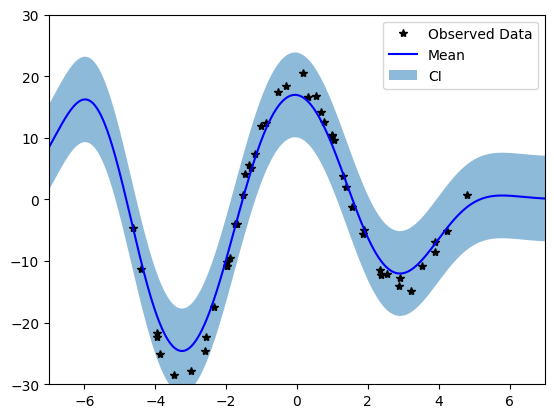

In [7]:
from matplotlib import pyplot as plt

with torch.no_grad():
    f, ax = plt.subplots(1, 1) # , figsize=(4, 3)

    observed_pred = likelihood(model(X_grid))
    lower, upper = observed_pred.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy(), 'k*')
    ax.plot(X_grid.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(X_grid.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-30, 30])
    ax.set_xlim([-7, 7])
    ax.legend(['Observed Data', 'Mean', 'CI'])

They look ok, but we can surely do better if we actually try to find good hyperparameters.

GPyTorch makes it easy to do this through the use of stochastic gradient descent. The specifics here aren't something we've really talked about, but we're basically just doing maximum likelihood estimation to choose optimal parameter values.

In order to actually maximize the likelihood, it's using a souped up version of SGD which uses all the nice toys we talked about in DSA.

In [8]:
N_iter = 2000
# Re-initialize
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)
model.train()
likelihood.train()

# Use the adam optimizer
# This is essentially just stochastic gradient descent.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(N_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    if (i + 1) % 100 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, N_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 100/2000 - Loss: 6.261   lengthscale: 0.911   noise: 4.169
Iter 200/2000 - Loss: 5.197   lengthscale: 0.914   noise: 5.428
Iter 300/2000 - Loss: 4.719   lengthscale: 0.916   noise: 6.255
Iter 400/2000 - Loss: 4.432   lengthscale: 0.918   noise: 6.840
Iter 500/2000 - Loss: 4.236   lengthscale: 0.919   noise: 7.253
Iter 600/2000 - Loss: 4.089   lengthscale: 0.920   noise: 7.530
Iter 700/2000 - Loss: 3.973   lengthscale: 0.921   noise: 7.686
Iter 800/2000 - Loss: 3.876   lengthscale: 0.922   noise: 7.730
Iter 900/2000 - Loss: 3.793   lengthscale: 0.923   noise: 7.661
Iter 1000/2000 - Loss: 3.719   lengthscale: 0.923   noise: 7.475
Iter 1100/2000 - Loss: 3.650   lengthscale: 0.923   noise: 7.158
Iter 1200/2000 - Loss: 3.583   lengthscale: 0.923   noise: 6.685
Iter 1300/2000 - Loss: 3.513   lengthscale: 0.923   noise: 6.015
Iter 1400/2000 - Loss: 3.434   lengthscale: 0.921   noise: 5.067
Iter 1500/2000 - Loss: 3.329   lengthscale: 0.919   noise: 3.679
Iter 1600/2000 - Loss: 3.158   len

Let's see how it did!

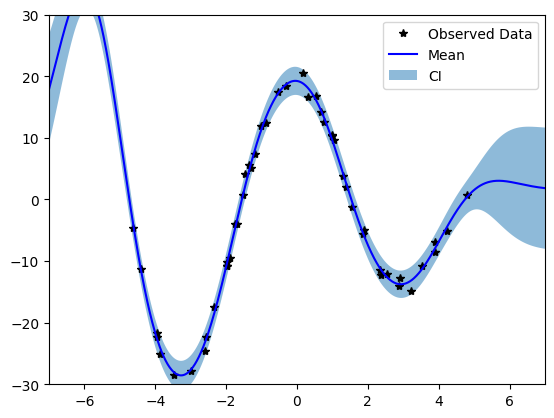

In [9]:
from matplotlib import pyplot as plt
model.eval()
likelihood.eval()
with torch.no_grad():
    f, ax = plt.subplots(1, 1)

    observed_pred = likelihood(model(X_grid))
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(X_grid.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(X_grid.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-30, 30])
    ax.set_xlim([-7, 7])
    ax.legend(['Observed Data', 'Mean', 'CI'])

Note that on the right-hand side, you see the quintessential thing that GPs do a good job with: increasing uncertainty when extrapolation is happening.

We can also think about this whole estimation process as building out a distribution of functions. Let's see what those functions look like!

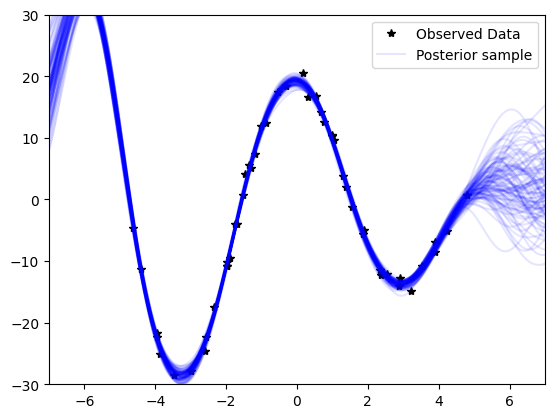

In [10]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1)

    observed_pred = likelihood(model(X_grid))
    # This is a total hack to get the appropriate samples from the model due to some
    # bugs in the gpytorch package.
    # Add a tiny amount to the diagonal to make sure the covariance is PSD
    sigma2 = model.likelihood.noise.item() - 1e-6
    L = torch.linalg.cholesky(observed_pred.covariance_matrix - torch.diag(torch.tensor([sigma2] * 1000)))
    lower, upper = observed_pred.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy(), 'k*')
    for i in range(100):
        ax.plot(X_grid.numpy(), observed_pred.mean + L @ torch.randn(1000, dtype=torch.double), 'b', alpha = 0.1)
    ax.set_ylim([-30, 30])
    ax.set_xlim([-7, 7])
    ax.legend(['Observed Data', 'Posterior sample'])

You can really visualize how this works when you look at the right side, now: the GP understands that there are a lot of potential functions that predict the data appropriately which start diverging on the right side.

# Conformalization

In this section, we're going to switch up the data we're working with by adding in some severe non-normal heteroskedasticity. We're going to walk through three approaches to getting some kind of prediction interval.

1. Assume the residuals of the model are distributed exactly normally.
2. Assume that a model predicting the size of residuals perfectly captures the variation in the residuals.
3. Use conformalization to ensure that you get good marginal coverage, no matter the distribution of the residuals.

In [11]:
def dgp(n):
    r = np.concatenate((
        np.random.uniform(-2,2,size = n // 5 + n % 5),
        np.random.uniform(-3,3,size = n // 5),
        np.random.uniform(-4,4,size = n // 5),
        np.random.uniform(-5,5,size = n // 5),
        np.random.uniform(-6,6,size = n // 5)
    ))
    y = noiseless(r) + np.random.exponential(scale = exp_scale(r), size = n) - exp_scale(r)
    ord = np.argsort(r)
    return np.hstack((r[ord])), y[ord]

def exp_scale(r):
    return 3 + 2 * np.cos(r + np.pi / 2)

This time, we need to pull both a validation dataset (in order to perform conformalization) and a test dataset (in which we will evaluate our approaches).

In [12]:
np.random.seed(100)

X_train, y_train = dgp(n = 800)
X_valid, y_valid = dgp(n = 200)
X_test, y_test = dgp(n = 10000)
X_grid = np.linspace(-7, 7, 1000)
y_grid = noiseless(X_grid)

Let's look at the data:

(-7.0, 7.0)

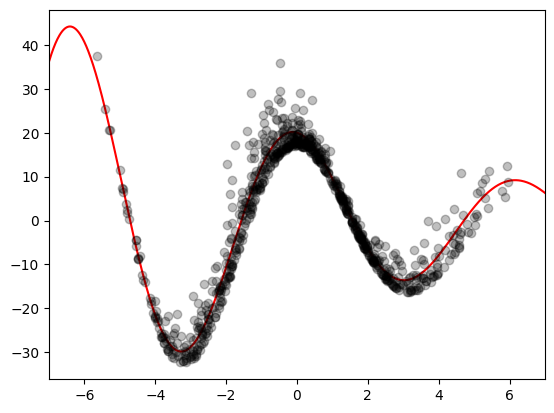

In [13]:
f, ax = plt.subplots(1, 1)
ax.plot(X_grid, y_grid, '-', color = "red")
ax.plot(X_train, y_train, 'o', color='black', alpha = 0.25)
ax.set_xlim([-7, 7])

And let's dig into what the residuals look like:

(-7.0, 7.0)

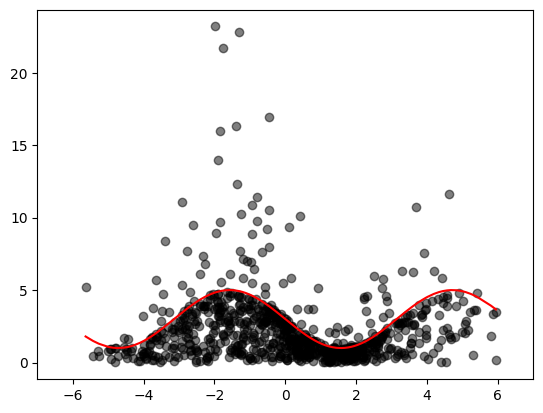

In [14]:
f, ax = plt.subplots(1, 1)
ax.plot(X_train, np.abs(y_train - noiseless(X_train)), 'o', color='black', alpha = 0.5)
ax.plot(X_train, exp_scale(X_train), '-', color='red')
ax.set_xlim([-7, 7])

We need to be careful about how we fit these models. Ideally, we want these two models to be completely independent of each other. The way I'll approximate this is to construct their models through cross-validation. The error model is fully dependent on the results of the mean model, but by using CV, I can know that the prediction for a given unit is independent of the label for that unit, so my error model should not be having issues of data leakage.

In [15]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor

cv = KFold(n_splits=20, shuffle = True, random_state = 101)
mean_model = GradientBoostingRegressor(n_estimators = 50)
error_model = GradientBoostingRegressor(n_estimators = 50, loss = "absolute_error")

mu = cross_val_predict(mean_model, X_train.reshape(-1, 1), y_train, cv=cv)
sigma = cross_val_predict(error_model, X_train.reshape(-1, 1), np.abs(y_train - mu), cv=cv)

mean_model.fit(X_train.reshape(-1, 1), y_train)
error_model.fit(X_train.reshape(-1, 1), np.abs(y_train - mu))

GradientBoostingRegressor(loss='absolute_error', n_estimators=50)

Let's take a look at how the mean predictor looks:

(-7.0, 7.0)

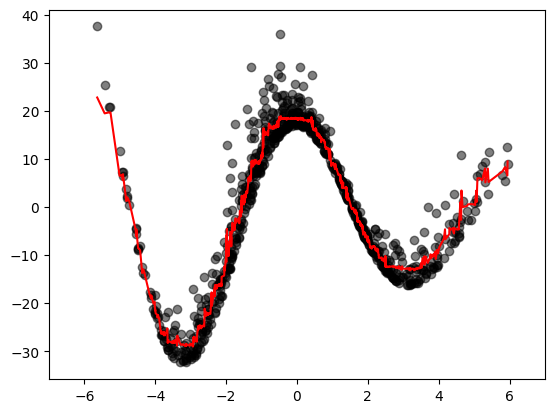

In [16]:
f, ax = plt.subplots(1, 1)
ax.plot(X_train, y_train, 'o', color='black', alpha = 0.5)
ax.plot(X_train, mu, '-', color='red')
ax.set_xlim([-7, 7])

Not too bad, although it clearly struggles on the right side where data is both sparse and residual variation is large.

How does our model of the errors do?

(-7.0, 7.0)

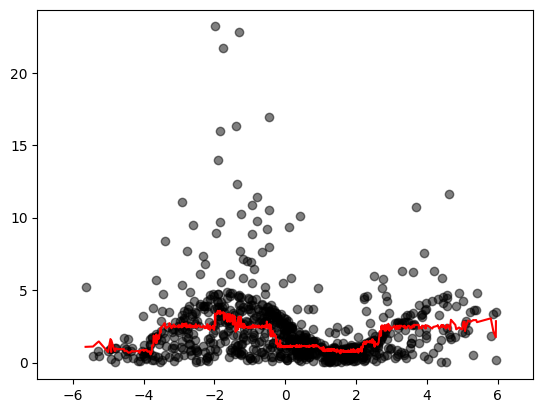

In [17]:
f, ax = plt.subplots(1, 1)
ax.plot(X_train, np.abs(y_train - noiseless(X_train)), 'o', color='black', alpha = 0.5)
ax.plot(X_train, sigma, '-', color='red')
ax.set_xlim([-7, 7])

Not amazing! But we can still get some reasonable performance out of the conformalization procedure.

Let's start by getting predictions for these models on the validation and test sets.

In [18]:
mu_valid = mean_model.predict(X_valid.reshape(-1, 1))
sigma_valid = error_model.predict(X_valid.reshape(-1, 1))

mu_test = mean_model.predict(X_test.reshape(-1, 1))
sigma_test = error_model.predict(X_test.reshape(-1, 1))

The simplest approach we can use was labelled (1) at the top. Let's just assume residuals are normal, calculate the RMSE in the validation set and use that to construct prediction intervals.

Note that we're assuming that residual variance is constant across the whole space, here!

(-7.0, 7.0)

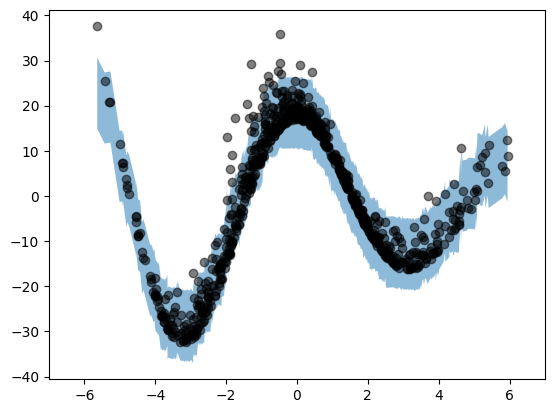

In [19]:
rmse = np.sqrt(np.average(np.power(mu_valid - y_valid, 2)))

f, ax = plt.subplots(1, 1)
ax.plot(X_train, y_train, 'o', color='black', alpha = 0.5)
ax.fill_between(X_train, mu - 1.96 * rmse, mu + 1.96 * rmse, alpha=0.5)
ax.set_xlim([-7, 7])

It's clearly not doing a great job: if you look in the area between 0.5 and 2 or so, the estimated interval is much too wide, while it appears like it might be too narrow in the -2 to 0 range. Let's see how it does on a test set.

In [20]:
width_1 = np.array([2 * 1.96 * rmse] * y_test.shape[0])

in_bounds = np.logical_and(y_test <= (mu_test + 1.96 * rmse), y_test >= (mu_test - 1.96 * rmse))
np.average(in_bounds)

0.9635

So it covers with about the rate we were hoping for (95%). How do those errors look by X value?

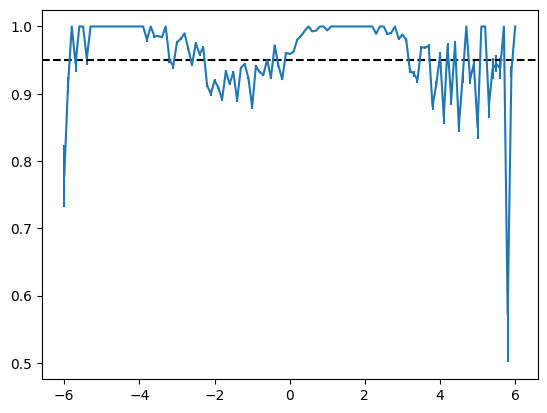

In [21]:
bins = np.round(X_test * 10, 0) / 10
unq_bins = np.unique(bins)
bin_means = [in_bounds[bins == i].mean() for i in unq_bins]
bin_se = [in_bounds[bins == i].std() / np.sum(bins == i) for i in unq_bins]

f, ax = plt.subplots(1, 1)
ax.errorbar(unq_bins, bin_means, bin_se)
ax.axhline(y=0.95, color = "black", linestyle = "--")

This plot shows the rate of coverage as a function of X. We can see that the same pattern we observed visually before holds in this more formal evaluation as well.

The next procedure we'll consider is to just use our error model directly, assuming conditional normality (but without assuming that the residual variance is constant across the whole space).

(-7.0, 7.0)

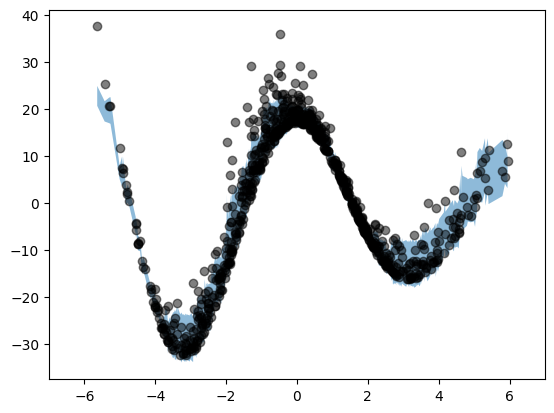

In [22]:
f, ax = plt.subplots(1, 1)
ax.plot(X_train, y_train, 'o', color='black', alpha = 0.5)
ax.fill_between(X_train, mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.5)
ax.set_xlim([-7, 7])

This appears to be dramatically understating the variance. Let's check in the test set:

In [23]:
width_2 = np.array(2 * 1.96 * sigma_test)

in_bounds = np.logical_and(y_test <= (mu_test + 1.96 * sigma_test), y_test >= (mu_test - 1.96 * sigma_test))
np.average(in_bounds)

0.8431

Yes, it is consistently undercovering the desired 95% coverage rate. How does it do by region of X?

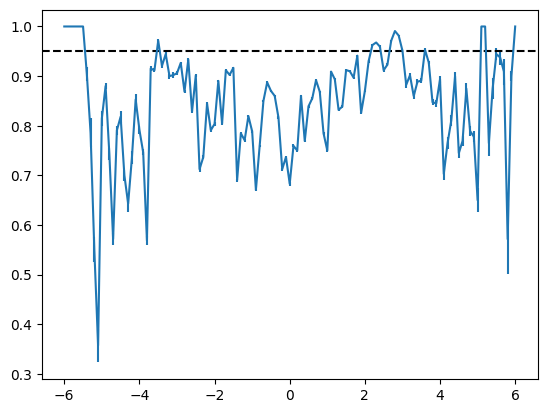

In [24]:
bins = np.round(X_test * 10, 0) / 10
unq_bins = np.unique(bins)
bin_means = [in_bounds[bins == i].mean() for i in unq_bins]
bin_se = [in_bounds[bins == i].std() / np.sum(bins == i) for i in unq_bins]

f, ax = plt.subplots(1, 1)
ax.errorbar(unq_bins, bin_means, bin_se)
ax.axhline(y=0.95, color = "black", linestyle = "--")

Only rarely does it cover at the appropriate rate, and some regions cover very poorly indeed (less than 50%!).

Finally, let's "conformalize" this procedure by choosing a scaling factor which will cover at the appropriate rate:

In [25]:
alpha = 0.05
n = y_train.shape[0]
conformal_score = np.abs(mu_valid - y_valid) / sigma_valid

qhat = np.quantile(conformal_score, np.ceil((n + 1) * (1 - alpha)) / n)
print(qhat)

4.280141086929616


Our scaling factor needs to be quite large! More than double what we would expect if our model correctly estimated the residual variation and the residuals were actually normally distributed.

(-7.0, 7.0)

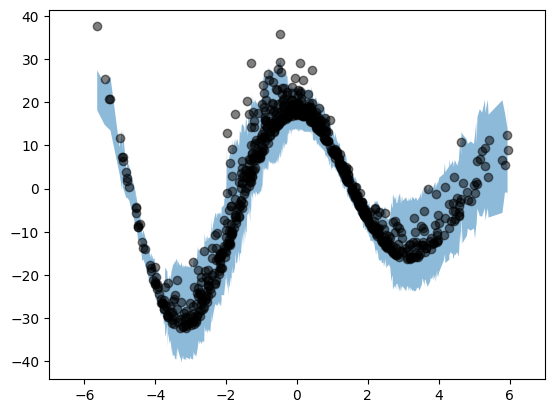

In [26]:
f, ax = plt.subplots(1, 1)
ax.plot(X_train, y_train, 'o', color='black', alpha = 0.5)
ax.fill_between(X_train, mu - qhat * sigma, mu + qhat * sigma, alpha=0.5)
ax.set_xlim([-7, 7])

In [27]:
width_3 = np.array(2 * qhat * sigma_test)

in_bounds = np.logical_and(y_test <= (mu_test + qhat * sigma_test), y_test >= (mu_test - qhat * sigma_test))
np.average(in_bounds)

0.9666

And we cover only slightly above the desired 95% rate. Perfect!

How do we do across the space of X? The conditional coverage is relatively good here, especially relative to the fixed width interval.

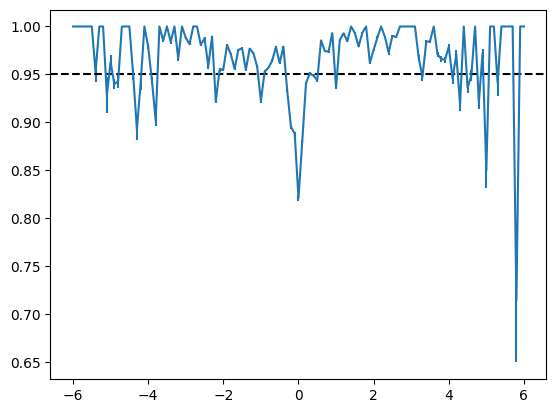

In [28]:
bins = np.round(X_test * 10, 0) / 10
unq_bins = np.unique(bins)
bin_means = [in_bounds[bins == i].mean() for i in unq_bins]
bin_se = [in_bounds[bins == i].std() / np.sum(bins == i) for i in unq_bins]

f, ax = plt.subplots(1, 1)
ax.errorbar(unq_bins, bin_means, bin_se)
ax.axhline(y=0.95, color = "black", linestyle = "--")

There are definitely areas of the space where we undercover by a bit, but this is certainly the best approach we evaluated in this section.

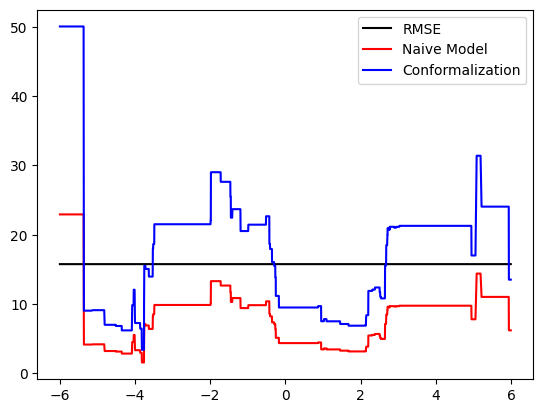

In [29]:
f, ax = plt.subplots(1, 1)
ax.plot(X_test, width_1, '-', color = "black")
ax.plot(X_test, width_2, '-', color = "red")
ax.plot(X_test, width_3, '-',color = "blue")
ax.legend(["RMSE", "Naive Model", "Conformalization"])

We can see that the naive model-based uncertainty has very narrow intervals, but it also doesn't cover at the appropriate rate. Conformalization is able to retain some of its adaptation to the data, while still maintaining guarantees on coverage. Thus, we can see that in much of the covariate space it has narrower confidence intervals than the fixed sized interval approach in black, but also sometimes has much wider confidence intervals.

Since both the fixed-size interval and the conformalized model approach have approximately the same coverage, the area over the curve (the blue line relative to the black one) will be about equal to the area below: we're just doing a better job of having wide intervals when they _should_ be wide (and narrow when they _should_ be narrow).